# Adaptive Learning with NV Centers - Data Analysis

## Import Modules

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from __future__ import division # Ensures that a/b is always a float.
from IPython.display import display, clear_output

import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import qinfer as qi
import models as m
import abc
import datetime
from time import sleep
from adaptive import *
import topchef_client
import scipy.stats as st
from scipy.interpolate import interp1d
import scipy.io as sio

/Users/ihincks/anaconda/envs/nvadapt/lib/python2.7/site-packages/matplotlib/style/core.py:197: UserWarning: In /Users/ihincks/.matplotlib/stylelib/ggplot-rq.mplstyle: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(message)


In [2]:
rabi_data = sio.loadmat('../data/rabi.mat')['avgData'] * 200 * 50000
rabi_p = (rabi_data[2,:] - rabi_data[1,:]) / (rabi_data[0,:] - rabi_data[1,:])
rabi_p_stds = est_std(rabi_p, rabi_data[0,:], rabi_data[1,:])
rabi_x = np.linspace(0,0.5,rabi_p.size)

ramsey_data = sio.loadmat('../data/ramsey.mat')['avgData'] * 200 * 50000
ramsey_p = (ramsey_data[2,:] - ramsey_data[1,:]) / (ramsey_data[0,:] - ramsey_data[1,:])
ramsey_p_stds = est_std(rabi_p, ramsey_data[0,:], ramsey_data[1,:])
ramsey_x = np.linspace(0, 2, ramsey_p.size)

/Users/ihincks/anaconda/envs/nvadapt/lib/python2.7/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [10]:
bernoulli_risk_11111 = HeuristicData('../data/bernoulli_risk_11111.pkl')
bernoulli_risk_11000 = HeuristicData('../data/bernoulli_risk_11000.pkl')
bernoulli_risk_new_prior = HeuristicData('../data/bernoulli_risk_new.pkl')
linear = HeuristicData('../data/alternating_linear.pkl')
panels = {
    'Predetermined Linear': linear,
    'Adaptive Risk': bernoulli_risk_11111
}

Imported existing Panel with 27 DataFrames from ../data/bernoulli_risk_11111.pkl
Imported existing Panel with 10 DataFrames from ../data/bernoulli_risk_11000.pkl
Imported existing Panel with 6 DataFrames from ../data/bernoulli_risk_new.pkl
Imported existing Panel with 29 DataFrames from ../data/alternating_linear.pkl


<IPython.core.display.Javascript object>


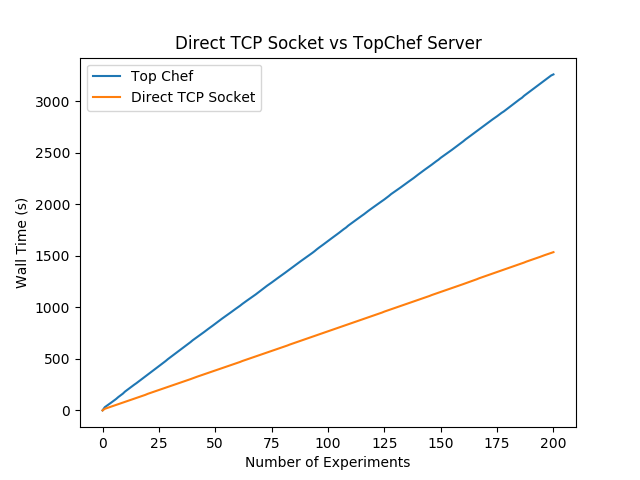

Imported existing Panel with 1 DataFrames from ../data/bernoulli_risk_new.pkl


In [14]:
fig = plt.figure()

df = bernoulli_risk_11111.panel[25]
plt.plot(np.array(list(df.cum_wall_time / Timedelta(seconds=1))), label='Top Chef')

df = HeuristicData('../data/bernoulli_risk_new.pkl').panel[0]
plt.plot(np.array(list(df.cum_wall_time / Timedelta(seconds=1))), label='Direct TCP Socket')

plt.title('Direct TCP Socket vs TopChef Server')
plt.ylabel('Wall Time (s)')
plt.xlabel('Number of Experiments')
plt.legend()

In [5]:
def extract_panel_data(panel, y_column, idxs=None, x_column=None, skip_first=False):
    """
    Extracts data from a HeuristicData object across data frames. It is assumed
    that all dataframes have the same number of rows.
    
    :param str y_column: Which column of the dataframes to extract.
    :param idxs: A numpy slice object (ex. np.s_[3,3]) to apply to the data
    entries, or None, to take everything.
    :param str x_column: Which column to use as the x-axis.
    
    :return: A tuple `(x_vals, y_vals)` where `y_vals is an
    `np.ndarray` of shape `(n_dataframes, n_rows, ...)` where the
    ellipsis is determined by the `idxs` pararameter.
    """
    n_df = panel.n_dataframes
    
    idxs = Ellipsis if idxs is None else idxs
    sample_y = panel.panel[0][y_column]
    if skip_first:
        row_idxs = np.s_[1:]
        n_rows = len(sample_y) - 1
        sample_y = sample_y[1][idxs]
    else:
        row_idxs = np.s_[:]
        n_rows = len(sample_y)
        sample_y = sample_y[0][idxs]
    
    y_data = np.empty((n_df, n_rows,) + sample_y.shape, dtype=sample_y.dtype)
    for idx_df in range(n_df):
        all_rows = np.array(list(panel.panel[idx_df][y_column][row_idxs]))
        try:
            y_data[idx_df, ...] = all_rows[(np.s_[:],) + idxs]
        except TypeError:
            y_data[idx_df, ...] = all_rows[(np.s_[:],) + (idxs,)]
    
    if x_column is None:
        x_data = np.arange(y_data.shape[1])
    else:
        sample_x = panel.panel[0][x_column]
        try:
            sample_x = np.array([sample_x[0]])
        except:
            sample_x = np.array([sample_x])
        assert sample_x.size == 1
            
        x_data_all = np.empty((n_df, n_rows), dtype=float)
        for idx_df in range(n_df):
            x_data = panel.panel[idx_df][x_column][row_idxs]
            try:
                x_data_all[idx_df, :] = x_data / Timedelta(seconds=1)
            except TypeError:
                x_data_all[idx_df, :] = list(x_data)
        
        x_data = np.linspace(
                np.amax(x_data_all[:,0]),
                np.amin(x_data_all[:,-1]),
                x_data_all.shape[1]
            )
        for idx_df in range(n_df):
            fun = interp1d(x_data_all[idx_df, :], y_data[idx_df, ...], axis=0)
            y_data[idx_df, ...] = fun(x_data)
        
        
    return x_data, y_data

<IPython.core.display.Javascript object>


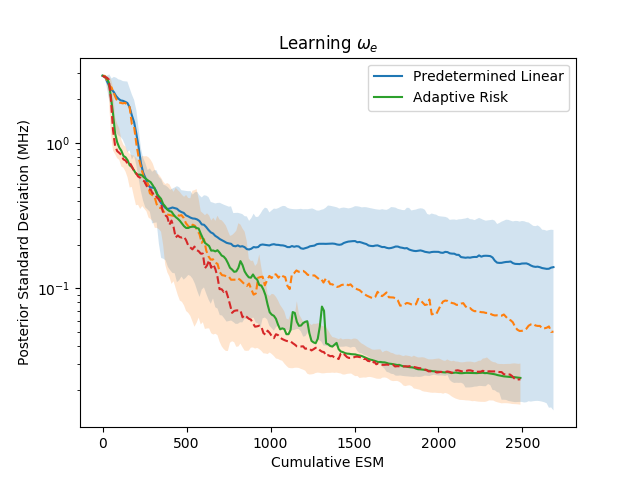

Predetermined Linear
Adaptive Risk


In [11]:
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
x_column='cum_eff_num_bits'

fig = plt.figure()

for name, panel in panels.iteritems():
    print name
    x_vals, y_vals = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,idx_param], x_column=x_column)
    lower, upper, mid = np.percentile(y_vals, [90,10,50], axis=0)
    plt.fill_between(x_vals, np.sqrt(lower), np.sqrt(upper), alpha=0.2)
    plt.semilogy(x_vals, np.sqrt(np.mean(y_vals, axis=0)), label=name)
    plt.semilogy(x_vals, np.sqrt(mid), '--')


plt.ylabel(r'Posterior Standard Deviation (MHz)')
plt.xlabel('Cumulative ESM')
plt.title('Learning ${}$'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


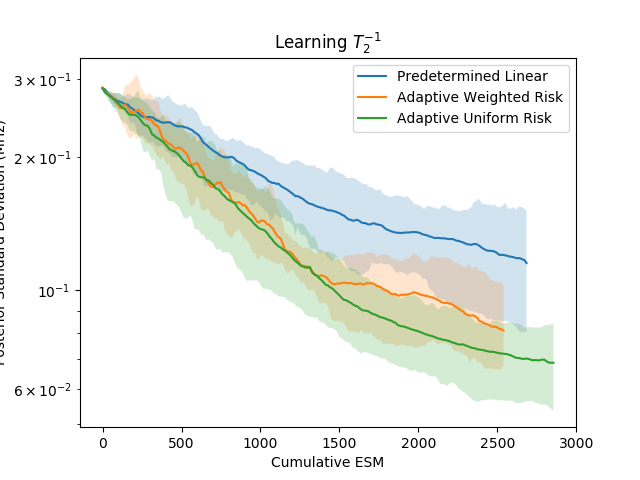

Predetermined Linear
Adaptive Weighted Risk
Adaptive Uniform Risk


In [129]:
idx_param = m.RabiRamseyModel.IDX_T2_INV
x_column='cum_eff_num_bits'

fig = plt.figure()

for name, panel in panels.iteritems():
    print name
    x_vals, y_vals = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,idx_param], x_column=x_column)
    lower, upper = np.percentile(y_vals, [90,10], axis=0)
    plt.fill_between(x_vals, np.sqrt(lower), np.sqrt(upper), alpha=0.2)
    plt.semilogy(x_vals, np.sqrt(np.mean(y_vals, axis=0)), label=name)


plt.ylabel(r'Posterior Standard Deviation (MHz)')
plt.xlabel('Cumulative ESM')
plt.title('Learning ${}$'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


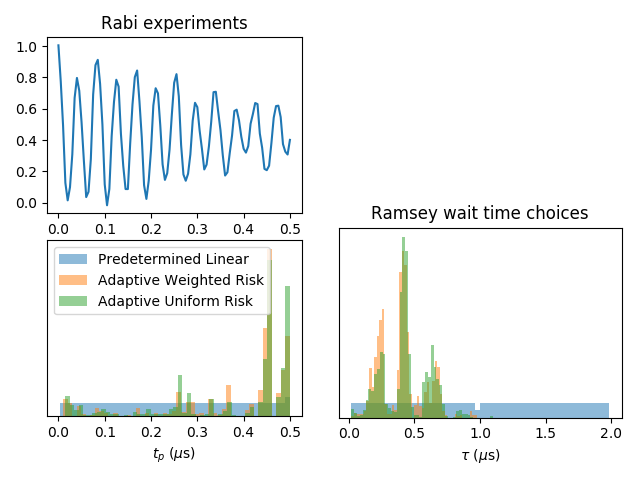

In [51]:
fig = plt.figure()
gs1 = gridspec.GridSpec(2,1,right=0.5)
gs2 = gridspec.GridSpec(2,1,left=0.5)

ax_rabi = plt.subplot(gs1[0,0])
plt.plot(rabi_x, rabi_p)
plt.title('Rabi experiments')

plt.subplot(gs1[1,0], sharex=ax_rabi)
for name, panel in panels.iteritems():
    _, eps_array = extract_panel_data(panel,'expparam',skip_first=True,idxs=np.s_[0])
    ts = eps_array['t'][eps_array['emode']==m.RabiRamseyModel.RABI]
    plt.hist(ts, bins=50, alpha=0.5, label=name, normed=True)
plt.xlabel(r'$t_p$ ($\mu$s)')

plt.legend()
plt.yticks([])

plt.subplot(gs2[1,0])
for name, panel in panels.iteritems():
    _, eps_array = extract_panel_data(panel,'expparam',skip_first=True,idxs=np.s_[0])
    ts = eps_array['tau'][eps_array['emode']==m.RabiRamseyModel.RAMSEY]
    plt.hist(ts, bins=50, alpha=0.5, label=name, normed=True)
plt.xlabel(r'$\tau$ ($\mu$s)')
plt.title('Ramsey wait time choices')
plt.yticks([])

gs1.tight_layout(fig,rect=(0,0,0.5,1),h_pad=0)
gs2.tight_layout(fig,rect=(0.5,0,1,1),h_pad=0)

<IPython.core.display.Javascript object>


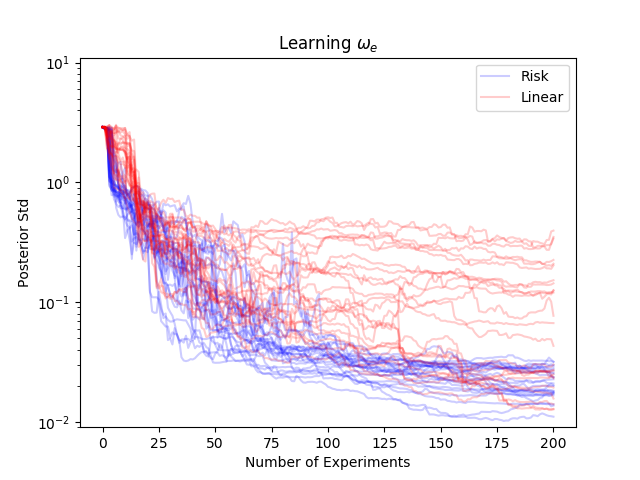

In [37]:
fig =plt.figure()
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
ham_model = m.RabiRamseyModel()

for idx_df in range(bernoulli_risk.n_dataframes):
    df = bernoulli_risk.panel[idx_df]
    label = 'Risk' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]), color='b',label=label,alpha=0.2)
    
for idx_df in range(linear.n_dataframes):
    df = linear.panel[idx_df]
    label = 'Linear' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]),'r',label=label, alpha=0.2)
    
plt.xlabel('Number of Experiments')
plt.ylabel('Posterior Std')
plt.ylim([0.9*10**-2,1.1*10])
plt.title('Learning ${}$'.format(ham_model.modelparam_names[idx_param]))
plt.legend()

Imported existing Panel with 24 DataFrames from ../data/bernoulli_risk.pkl


<IPython.core.display.Javascript object>


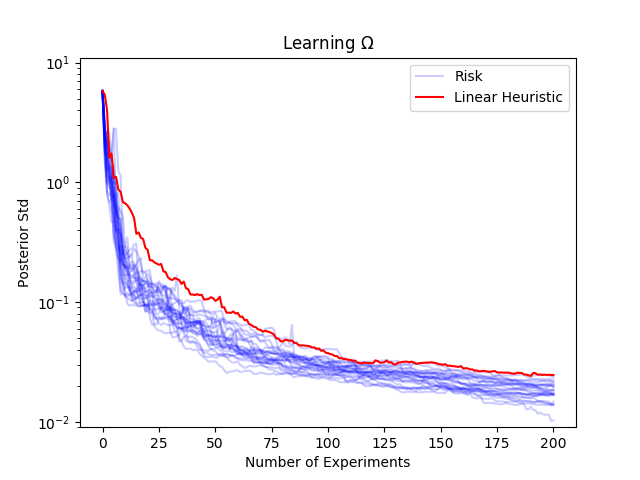

Imported existing Panel with 2 DataFrames from ../data/linear_heuristic_9.pkl


In [4]:
panel_bernoulli_risk = HeuristicData('../data/bernoulli_risk.pkl')
fig =plt.figure()
idx_param = m.RabiRamseyModel.IDX_OMEGA
ham_model = m.RabiRamseyModel()

for idx_df in range(panel_bernoulli_risk.n_dataframes):
    df = panel_bernoulli_risk.panel[idx_df]
    label = 'Risk' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]), color='b',label=label,alpha=0.2)
    
panel_linear = HeuristicData('../data/linear_heuristic_9.pkl')
for idx_df in range(1,panel_linear.n_dataframes):
    df = panel_linear.panel[idx_df]
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]),'r',label='Linear Heuristic')
    
plt.xlabel('Number of Experiments')
plt.ylabel('Posterior Std')
plt.ylim([0.9*10**-2,1.1*10])
plt.title('Learning ${}$'.format(ham_model.modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


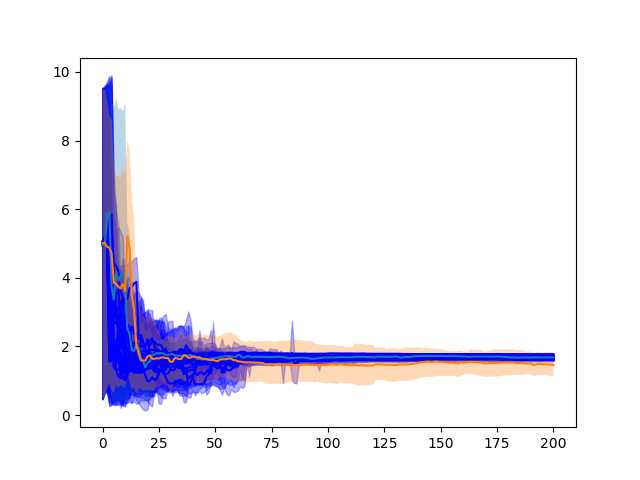

In [9]:
fig = plt.figure()
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
for idx_df in range(panel_bernoulli_risk.n_dataframes):
    df = panel_bernoulli_risk.panel[idx_df]
    plt.plot(np.array(list(df.smc_mean))[:,idx_param], color='b')
    plt.fill_between(
        np.arange(201),
        np.array(list(df.smc_lower_quantile))[:,idx_param],
        np.array(list(df.smc_upper_quantile))[:,idx_param],
        alpha=0.3,
        color='b'
    )
    
for idx_df in range(panel_linear.n_dataframes):
    df = panel_linear.panel[idx_df]
    plt.plot(np.array(list(df.smc_mean))[:,idx_param])
    plt.fill_between(
        np.arange(201),
        np.array(list(df.smc_lower_quantile))[:,idx_param],
        np.array(list(df.smc_upper_quantile))[:,idx_param],
        alpha=0.3
    )

In [14]:
panel_bernoulli_risk.panel[idx_trial]

,expparam,bright,dark,signal,completed_ts,returned_ts,submitted_ts,diff_time,run_time,wall_time,...,cum_eff_num_bits,heuristic,heuristic_value,smc_mean,smc_cov,smc_n_eff_particles,smc_resample_count,smc_upper_quantile,smc_lower_quantile,n_meas
0,NaN,NaN,NaN,NaN,2017-12-22 18:36:40.220220,2017-12-22 18:36:40.220220,2017-12-22 18:36:40.220220,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,...,0,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[9.92805198513, 5.02322176241, -0.023777263261...","[[33.9028066642, 0.187569092817, 0.09046272026...",10000,0,"[19.0134976645, 9.52023014449, 4.5131629974, 3...","[1.00873579971, 0.484180015804, -4.51219910337...",NaN
1,"[[0.015, 0.0, 0.0, 0.0, 0, 0, 200000]]",3579,2911,3065,2017-12-22 18:36:50.785000,2017-12-22 18:36:56.745142,2017-12-22 18:36:48.295377,0 days 00:00:10.564780,0 days 00:00:05.533000,0 days 00:00:08.449765,...,12.9423,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[13.2126284503, 5.11013869095, 0.0508407522262...","[[7.91606243927, -0.100954477883, 0.3740244062...",10000,1,"[19.1813399225, 9.51869112858, 4.57858459133, ...","[9.77092808904, 0.691867837524, -4.46712251204...",[200000]
2,"[[0.015, 0.0, 0.0, 0.0, 0, 0, 200000]]",3621,2896,3136,2017-12-22 18:36:58.585000,2017-12-22 18:37:04.931293,2017-12-22 18:36:56.093215,0 days 00:00:07.800000,0 days 00:00:05.533000,0 days 00:00:08.838078,...,28.5279,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[11.1824520889, 5.34607609511, -0.041586819261...","[[1.63711775987, 0.316802123316, 0.10079072250...",10000,2,"[13.0165759717, 9.625138894, 4.47719099802, 3....","[9.56911458928, 0.863467799594, -4.46862060578...",[200000]
3,"[[0.025, 0.0, 0.0, 0.0, 0, 0, 200000]]",3484,2892,2963,2017-12-22 18:37:07.112000,2017-12-22 18:37:13.192726,2017-12-22 18:37:04.470402,0 days 00:00:08.527000,0 days 00:00:05.535000,0 days 00:00:08.722324,...,38.9095,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[11.1377160593, 5.31311554138, -0.017269220837...","[[1.05077557082, 0.370495682735, 0.08912847952...",7493.11,2,"[12.8758337052, 9.61662642422, 4.55694447495, ...","[9.53782711869, 0.811873820977, -4.53314287791...",[200000]
4,"[[0.045, 0.0, 0.0, 0.0, 0, 0, 200000]]",3579,2806,3429,2017-12-22 18:37:15.561000,2017-12-22 18:37:21.478428,2017-12-22 18:37:12.770870,0 days 00:00:08.449000,0 days 00:00:05.539000,0 days 00:00:08.707558,...,58.2991,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[10.9389482421, 1.61764132607, 0.117377054268,...","[[0.511251986427, 0.0105256333763, -0.08856418...",10000,3,"[12.1312328427, 3.04106145526, 4.61361106363, ...","[9.83253480839, 0.303025212935, -4.22342956695...",[200000]
5,"[[0.045, 0.0, 0.0, 0.0, 0, 0, 200000]]",3577,2864,3317,2017-12-22 18:37:23.768000,2017-12-22 18:37:29.510516,2017-12-22 18:37:21.001916,0 days 00:00:08.207000,0 days 00:00:05.539000,0 days 00:00:08.508600,...,73.3761,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[10.914626742, 1.92773630888, 0.216932502561, ...","[[0.618424428685, 0.0068124684935, -0.10551799...",5452.94,3,"[12.2474151377, 3.25571084735, 4.65800335872, ...","[9.70982190799, 0.431458252177, -4.21180921028...",[200000]
6,"[[0.1, 0.0, 0.0, 0.0, 0, 0, 200000]]",3500,2870,2905,2017-12-22 18:37:31.824000,2017-12-22 18:37:37.604133,2017-12-22 18:37:29.069421,0 days 00:00:08.056000,0 days 00:00:05.550000,0 days 00:00:08.534712,...,86.3094,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[11.8609580278, 1.88772493062, 0.411648583422,...","[[0.15672522945, -0.167006391557, -0.050310005...",10000,4,"[12.537038537, 3.30416168973, 4.86440276956, 3...","[11.2495925294, 0.394406098062, -4.39773077373...",[200000]
7,"[[0.1, 0.0, 0.0, 0.0, 0, 0, 200000]]",3505,2854,2993,2017-12-22 18:37:39.598000,2017-12-22 18:37:46.006464,2017-12-22 18:37:36.980543,0 days 00:00:07.774000,0 days 00:00:05.550000,0 days 00:00:09.025921,...,98.7203,"Bayes Risk, Q=[1, 1, 1, 1, 1] (with tracking)",None,"[11.7314836005, 2.00029633996, 0.36261778287, ...","[[0.163723824128

<IPython.core.display.Javascript object>


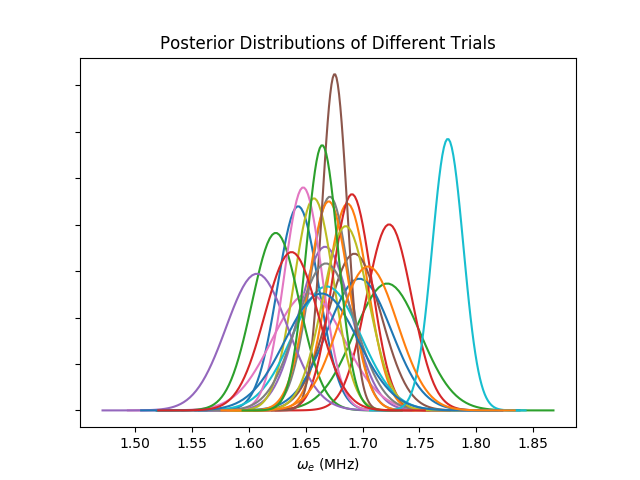

[]

In [156]:
fig = plt.figure()
idx_param = 1
for idx_trial in range(bernoulli_risk.n_dataframes):
    mean = np.array(list(bernoulli_risk.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(bernoulli_risk.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std))
    
plt.title('Posterior Distributions of Different Trials')
plt.xlabel('${}$ (MHz)'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.gca().set_yticklabels([])

<IPython.core.display.Javascript object>


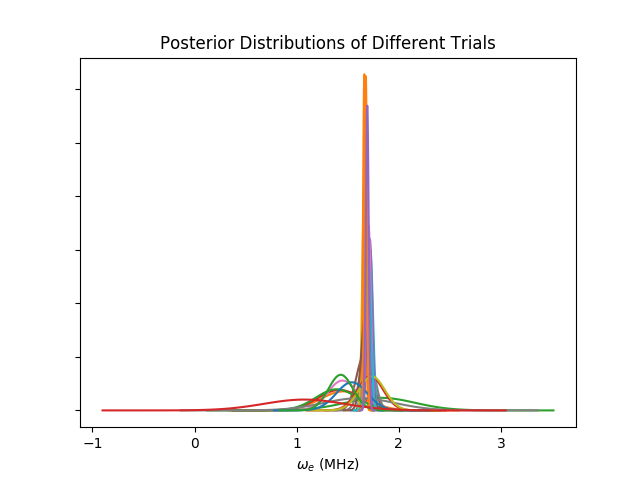

[]

In [41]:
fig = plt.figure()
idx_param = 1
for idx_trial in range(linear.n_dataframes):
    mean = np.array(list(linear.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(linear.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std))
    
plt.title('Posterior Distributions of Different Trials')
plt.xlabel('${}$ (MHz)'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.gca().set_yticklabels([])